In [143]:
import pandas as pd
import ternary
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk')

from borfr import BO_RFR, fps
import warnings
warnings.filterwarnings("ignore")
from synth_data.plotting_helpers_mixture_frederic import plot_mixture_4d



df = pd.read_csv('data_cond/calisol23_DOI_10.11583DTU.c.6929599.csv',sep=',')
inds1 = np.where(df['c units'].values == 'mol/kg')[0]
inds2 = np.where(df['solvent ratio type'].values == 'w')[0]
inds = np.array(list(set(inds1).intersection(set(inds2))))
#inds = np.arange(df.values.shape[0])

inds2 = np.where(df['k'].values <= 39.)[0]
inds = np.array(list(set(inds).intersection(set(inds2))))

inds2 = np.where(np.isfinite(df['k'].values) == True)[0]
inds = np.array(list(set(inds).intersection(set(inds2))))

#inds2 = np.where(df['solvent ratio type'].values == 'w')[0]
#inds = np.array(list(set(inds).intersection(set(inds2))))

conds = df['k'].values[inds]
cols = ['T', 'c', 'salt', 'EC', 'PC', 'DMC', 'EMC', 'DEC', 'DME', 'TFP', 'EA', 'MA', 'FEC',]



In [144]:
salt = np.zeros(inds.shape)
salts = np.unique(df['salt'].values[inds])
for ii,i in enumerate(salts):
    salt[df['salt'].values[inds]==i] = ii
df = pd.DataFrame(df[cols].values[inds], columns=cols)
df['salt'] = salt



<Axes: ylabel='Density'>

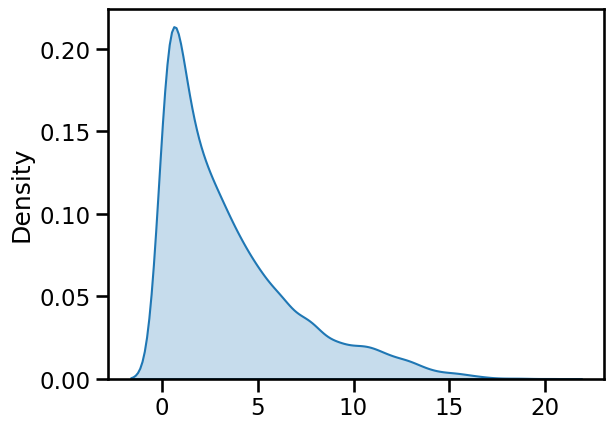

In [191]:
fig,ax = plt.subplots()
sns.kdeplot(conds, gridsize=200, fill=True)

In [192]:
def f(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    return vals[ind]

def get_label(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    return ref_labels[ind]


grid = np.array(df.values, dtype=float)
vals = conds

ref_labels = np.zeros(conds.shape)
ref_labels[conds > 10.] = 1.


In [262]:
np.random.seed(5)

X_init = fps(grid,20)
#X_init = grid[np.random.randint(0,171,4)]
y_init = np.array([f(xi) for xi in X_init])

x_test = grid

regm = 'RFC'
clm = 'RFC'

esl = 'AC'

n_iter = 250
nb = 8
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.1, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm)

bor.run(n_iter_b)

rand_scores = []
for i in range(3):
    rand = BO_RFR(X_init, y_init, grid, f, x_test, 
                  acq='random',gl = get_label,  
                  est_labels=esl, N_batch=1,
                  class_method = clm, reg_method = regm)
    
    rand.run(n_iter)
    rand_scores.append(rand.scores)


sf = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm)

sf.run(n_iter)

generating test data


100%|█████████████████████████████████████| 9725/9725 [00:01<00:00, 9088.92it/s]


running iterative exploration:


100%|███████████████████████████████████████████| 31/31 [00:17<00:00,  1.78it/s]


generating test data


100%|█████████████████████████████████████| 9725/9725 [00:01<00:00, 8860.95it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 250/250 [01:23<00:00,  2.98it/s]


generating test data


100%|████████████████████████████████████| 9725/9725 [00:00<00:00, 11289.23it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 250/250 [01:12<00:00,  3.43it/s]


generating test data


100%|████████████████████████████████████| 9725/9725 [00:00<00:00, 12023.11it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 250/250 [01:11<00:00,  3.52it/s]


generating test data


100%|████████████████████████████████████| 9725/9725 [00:00<00:00, 11730.89it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 250/250 [01:13<00:00,  3.42it/s]


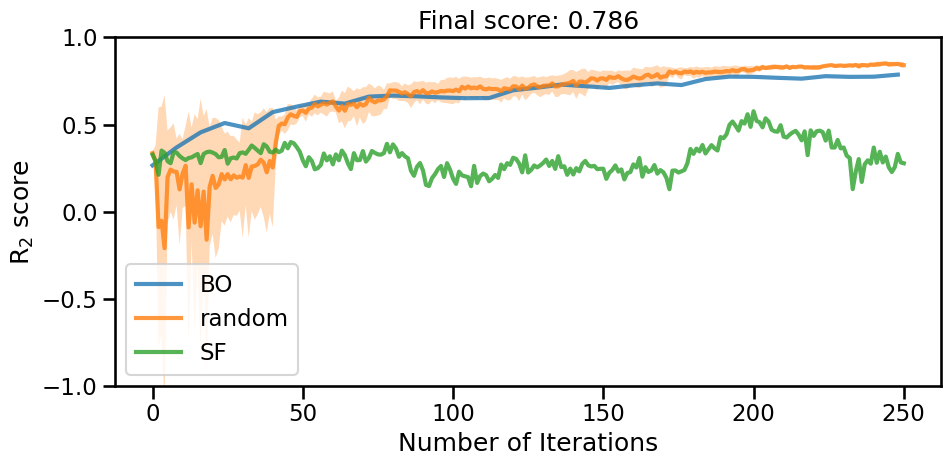

In [263]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(-1,1)
ax2.legend()
plt.tight_layout()

(array([2.20964061e-01, 1.10939829e-01, 6.72455086e-02, 4.12527288e-02,
        2.24829915e-02, 1.79558733e-02, 8.95250341e-03, 2.44159184e-03,
        7.12130953e-04, 2.03465987e-04]),
 array([ 0.        ,  2.02777778,  4.05555556,  6.08333333,  8.11111111,
        10.13888889, 12.16666667, 14.19444445, 16.22222222, 18.25      ,
        20.27777778]),
 <BarContainer object of 10 artists>)

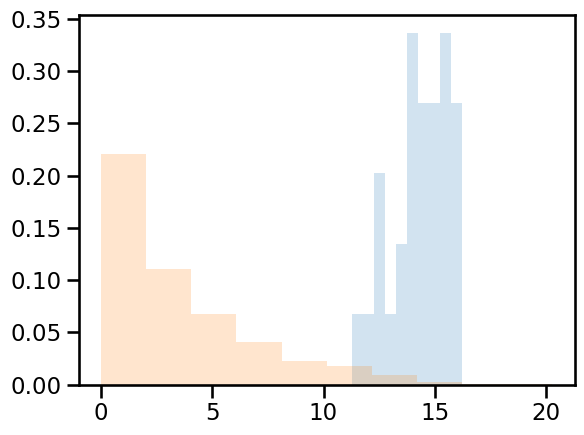

In [260]:
blabs = bor.classifier.predict(grid)
fig,ax = plt.subplots()
ax.hist(vals[blabs==0],alpha=0.2, density=True)
ax.hist(vals[blabs==1],alpha=0.2, density=True)

0.9937856033143448

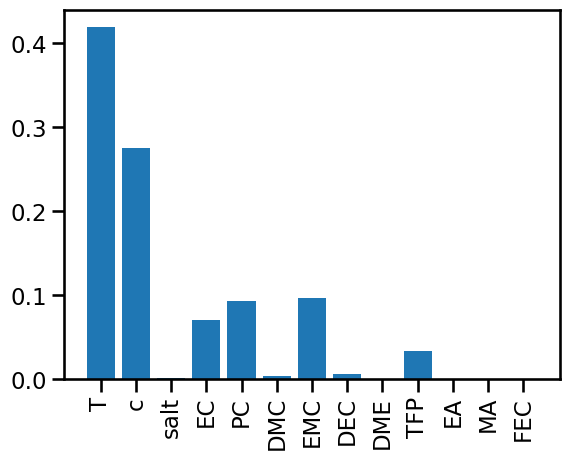

In [261]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler

X = StandardScaler().fit_transform(grid)

lda = LDA().fit(X, blabs)


fig,ax=plt.subplots()
ax.bar(range(len(cols)), bor.classifier.feature_importances_)
ax.set_xticks(range(len(cols)), labels=cols, rotation=90)

f1_score(blabs, lda.predict(X))

(array([32.92074953,  0.        ,  0.        ,  0.13752794,  0.        ,
         0.        ,  0.13752794,  0.        ,  0.        ,  0.13752794]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ]),
 <BarContainer object of 10 artists>)

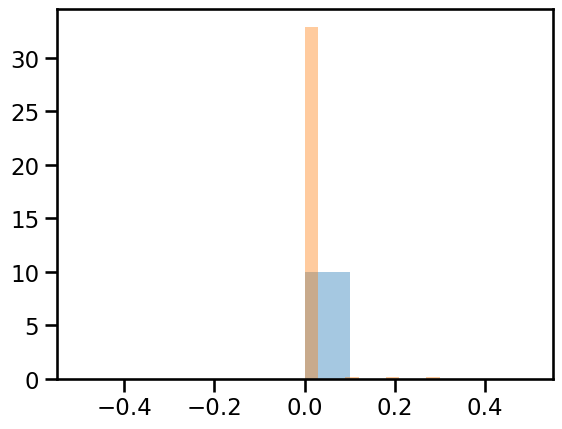

In [258]:
rats1 = grid[blabs==0][:,-2]
rats1 = rats1[np.isfinite(rats1)]

rats2 = grid[blabs==1][:,-2]
rats2 = rats2[np.isfinite(rats2)]
fig,ax = plt.subplots()
ax.hist(rats1,alpha=0.4,density=True)
ax.hist(rats2,alpha=0.4,density=True)

In [241]:
X[:,3].max()

1.0